<a href="https://colab.research.google.com/github/dathere/notebooks/blob/master/Realtime_Rt_mcmc_NJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimating COVID-19's $R_t$ in Real-Time for all US counties

Modified version of the work by [Kevin Systrom](https://github.com/k-sys/covid-19) to estimate $R_t$ for all US states based on the [NYT](https://github.com/nytimes/covid-19-data) county level data

In [0]:
!pip install pymc3==3.8

     |████████████████████████████████| 911kB 4.6MB/s 
     |████████████████████████████████| 1.5MB 29kB/s 
     |████████████████████████████████| 4.1MB 15.2MB/s 
     |████████████████████████████████| 327kB 34.3MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

## Load COUNTY Information

In [0]:
# Import NYT data
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
counties = pd.read_csv(url,parse_dates=['date']).sort_index()

counties = counties.loc[counties['state'] == 'New Jersey']
counties.drop(columns=['fips'], inplace=True)

counties

,date,county,state,cases,deaths
517,2020-03-04,Bergen,New Jersey,1,0
563,2020-03-05,Bergen,New Jersey,2,0
624,2020-03-06,Bergen,New Jersey,3,0
625,2020-03-06,Camden,New Jersey,1,0
712,2020-03-07,Bergen,New Jersey,3,0
...,...,...,...,...,...
145981,2020-05-15,Somerset,New Jersey,4181,359
145982,2020-05-15,Sussex,New Jersey,1047,137
145983,2020-05-15,Union,New Jersey,14492,939
145984,2020-05-15,Unknown,New Jersey,885,0


In [0]:
#Create Northern, Central and Southern NJ aggregations and add them as pseudo-counties
northjersey_counties = ['Bergen','Union','Essex','Hudson','Morris','Passaic','Sussex','Warren']
centraljersey_counties = ['Middlesex', 'Monmouth', 'Ocean', 'Mercer','Somerset', 'Hunterdon']
southjersey_counties = ['Atlantic', 'Burlington','Camden', 'Cape May', 'Cumberland', 'Gloucester', 'Salem']

nnj_counties = counties.loc[counties['county'].isin(northjersey_counties)]
cnj_counties = counties.loc[counties['county'].isin(centraljersey_counties)]
snj_counties = counties.loc[counties['county'].isin(southjersey_counties)]

nnj_counties.set_index(['date'], inplace=True)
nnj_counties = nnj_counties.sum(level='date')
nnj_counties['county'] = 'North Jersey'
nnj_counties['state'] = 'New Jersey'
nnj_counties.reset_index(inplace=True)


cnj_counties.set_index(['date'], inplace=True)
cnj_counties = cnj_counties.sum(level='date')
cnj_counties['county'] = 'Central Jersey'
cnj_counties['state'] = 'New Jersey'
cnj_counties.reset_index(inplace=True)


snj_counties.set_index(['date'], inplace=True)
snj_counties = snj_counties.sum(level='date')
snj_counties['county'] = 'South Jersey'
snj_counties['state'] = 'New Jersey'
snj_counties.reset_index(inplace=True)

nnj_counties
counties = pd.concat([counties, nnj_counties, cnj_counties, snj_counties])
counties

,date,county,state,cases,deaths
517,2020-03-04,Bergen,New Jersey,1,0
563,2020-03-05,Bergen,New Jersey,2,0
624,2020-03-06,Bergen,New Jersey,3,0
625,2020-03-06,Camden,New Jersey,1,0
712,2020-03-07,Bergen,New Jersey,3,0
...,...,...,...,...,...
66,2020-05-11,South Jersey,New Jersey,14083,677
67,2020-05-12,South Jersey,New Jersey,14324,709
68,2020-05-13,South Jersey,New Jersey,14491,738
69,2020-05-14,South Jersey,New Jersey,14751,786


In [0]:
#counties[counties.county != 'Unknown']
counties=counties[counties.county != 'Unknown']
counties.insert(0, 'key', counties['state'] + '_' + counties['county'])
counties.set_index(['key', 'date'],inplace=True)

# Example
#print(counties[counties['state'] == "Maine"]['county'].unique())
counties

county       state  cases  deaths
key                     date                                               
New Jersey_Bergen       2020-03-04        Bergen  New Jersey      1       0
                        2020-03-05        Bergen  New Jersey      2       0
                        2020-03-06        Bergen  New Jersey      3       0
New Jersey_Camden       2020-03-06        Camden  New Jersey      1       0
New Jersey_Bergen       2020-03-07        Bergen  New Jersey      3       0
...                                          ...         ...    ...     ...
New Jersey_South Jersey 2020-05-11  South Jersey  New Jersey  14083     677
                        2020-05-12  South Jersey  New Jersey  14324     709
                        2020-05-13  South Jersey  New Jersey  14491     738
                        2020-05-14  South Jersey  New Jersey  14751     786
                        2020-05-15  South Jersey  New Jersey  14991     819

[1548 rows x 4 columns]

In [0]:
# Import NYT data
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
states = pd.read_csv(url,parse_dates=['date']).sort_index()

states = states.loc[states['state']=='New Jersey']
states.drop(columns=['fips'], inplace=True)

states

,date,state,cases,deaths
292,2020-03-04,New Jersey,1,0
312,2020-03-05,New Jersey,2,0
337,2020-03-06,New Jersey,4,0
368,2020-03-07,New Jersey,4,0
403,2020-03-08,New Jersey,6,0
...,...,...,...,...
3840,2020-05-11,New Jersey,139945,9310
3895,2020-05-12,New Jersey,140743,9508
3950,2020-05-13,New Jersey,141560,9702
4005,2020-05-14,New Jersey,142704,9946


In [0]:
#counties[counties.county != 'Unknown']
states=states[states.state != 'Unknown']
states.insert(0, 'key', states['state'] + '_' + states['state'])
states.set_index(['key', 'date'],inplace=True)

# Example
#print(counties[counties['state'] == "Maine"]['county'].unique())
states['county'] = states['state']
print(states.head())

                                       state  cases  deaths      county
key                   date                                             
New Jersey_New Jersey 2020-03-04  New Jersey      1       0  New Jersey
                      2020-03-05  New Jersey      2       0  New Jersey
                      2020-03-06  New Jersey      4       0  New Jersey
                      2020-03-07  New Jersey      4       0  New Jersey
                      2020-03-08  New Jersey      6       0  New Jersey


In [0]:
#concatenate county and state

counties = pd.concat([counties, states])

## Load Patient Information
#### Download
~100mb download (be ... patient!)

In [0]:
def download_file(url, local_filename):
    """From https://stackoverflow.com/questions/16694907/"""
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
    return local_filename


#URL = "https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv"
URL = "https://github.com/beoutbreakprepared/nCoV2019/raw/master/latest_data/latestdata.tar.gz"

LINELIST_PATH = 'data/linelist.csv.gz'

os.makedirs(os.path.dirname(LINELIST_PATH), exist_ok=True)

if not os.path.exists(LINELIST_PATH):
    print('Downloading file, this will take a while ~100mb')
    try:
        download_file(URL, LINELIST_PATH)
        clear_output(wait=True)
        print('Done downloading.')
    except:
        print('Something went wrong. Try again.')
else:
    print('Already downloaded CSV')

Done downloading.


In [0]:
#unzip file

import gzip
import shutil
with gzip.open(LINELIST_PATH, 'rb') as f_in:
    with open('data/linelist.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

#### Parse & Clean Patient Info

In [0]:
# Load the patient CSV
patients = pd.read_csv(
    'data/linelist.csv',
    parse_dates=False,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)

patients.columns = ['Onset', 'Confirmed']
# colnames renamed ~05-07. rename back for code below to work
#patients.columns =  ['date_confirmation', 'date_onset_symptoms']

# There's an errant reversed date
patients = patients.replace('01.31.2020', '31.01.2020')

# Only keep if both values are present
patients = patients.dropna()

# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')

# Only keep records where confirmed > onset
patients = patients[patients.Confirmed >= patients.Onset]

#### Show Relationship between Onset of Symptoms and Confirmation

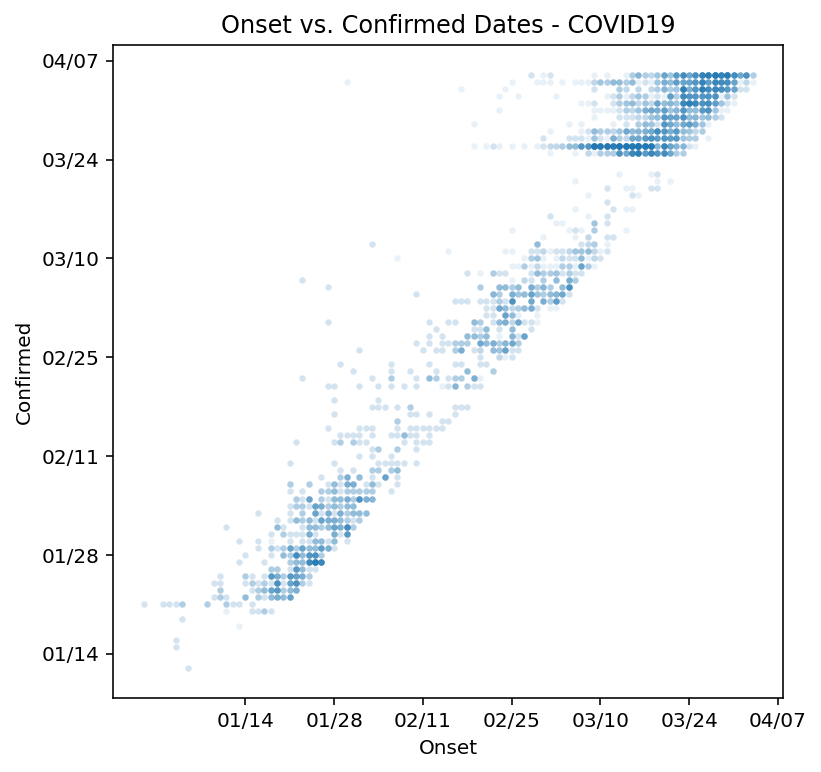

In [0]:
ax = patients.plot.scatter(
    title='Onset vs. Confirmed Dates - COVID19',
    x='Onset',
    y='Confirmed',
    alpha=.1,
    lw=0,
    s=10,
    figsize=(6,6))

formatter = mdates.DateFormatter('%m/%d')
locator = mdates.WeekdayLocator(interval=2)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(formatter)
    axis.set_major_locator(locator)

#### Calculate the Probability Distribution of Delay

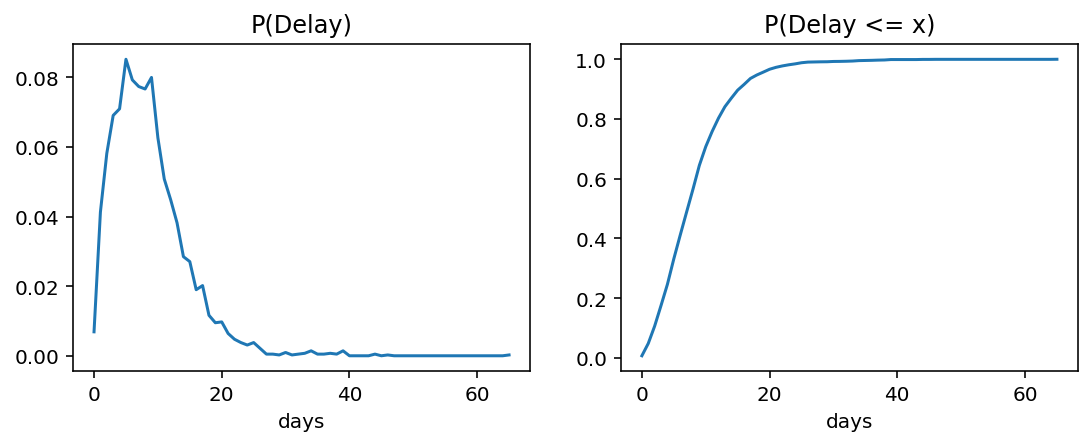

In [0]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
p_delay.plot(title='P(Delay)', ax=axes[0])
p_delay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')

# A single County

In [0]:
#key = 'Nebraska_Douglas'
#key = 'NYC_NYC'
#key = 'New York_New York City'
key = 'New Jersey_Hudson'
confirmed = counties.xs(key).cases.diff().dropna().clip(0) # new cases (not cumulative)
confirmed.tail()

date
2020-05-11    114.0
2020-05-12     39.0
2020-05-13     60.0
2020-05-14     99.0
2020-05-15    103.0
Name: cases, dtype: float64

### Translate Confirmation Dates to Onset Dates

Our goal is to translate positive test counts to the dates where they likely occured. Since we have the distribution, we can distribute case counts back in time according to that distribution. To accomplish this, we reverse the case time series, and convolve it using the distribution of delay from onset to confirmation. Then we reverse the series again to obtain the onset curve. Note that this means the data will be 'right censored' which means there are onset cases that have yet to be reported so it looks as if the count has gone down.

In [0]:
def confirmed_to_onset(confirmed, p_delay):

    assert not confirmed.isna().any()
    
    # Reverse cases so that we convolve into the past
    convolved = np.convolve(confirmed[::-1].values, p_delay)

    # Calculate the new date range
    dr = pd.date_range(end=confirmed.index[-1],
                       periods=len(convolved))

    # Flip the values and assign the date range
    onset = pd.Series(np.flip(convolved), index=dr)
    
    return onset



In [0]:
# onset for the selected county
onset = confirmed_to_onset(confirmed, p_delay)

### Adjust for Right-Censoring

Since we distributed observed cases into the past to recreate the onset curve, we now have a right-censored time series. We can correct for that by asking what % of people have a delay less than or equal to the time between the day in question and the current day.

For example, 5 days ago, there might have been 100 cases onset. Over the course of the next 5 days some portion of those cases will be reported. This portion is equal to the cumulative distribution function of our delay distribution. If we know that portion is say, 60%, then our current count of onset on that day represents 60% of the total. This implies that the total is 166% higher. We apply this correction to get an idea of what actual onset cases are likely, thus removing the right censoring.

In [0]:
def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        constant_values=1)
    cumulative_p_delay = np.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay

In [0]:
# adjusted for the selected county
adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)

Take a look at all three series: confirmed, onset and onset adjusted for right censoring.

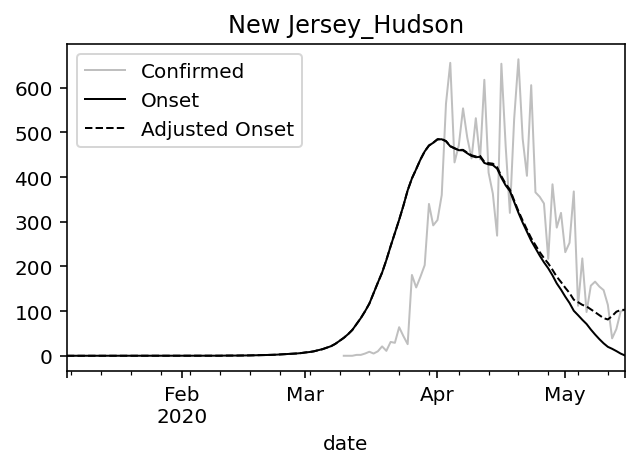

In [0]:
fig, ax = plt.subplots(figsize=(5,3))

confirmed.plot(
    ax=ax,
    label='Confirmed',
    title=key,
    c='k',
    alpha=.25,
    lw=1)

onset.plot(
    ax=ax,
    label='Onset',
    c='k',
    lw=1)

adjusted.plot(
    ax=ax,
    label='Adjusted Onset',
    c='k',
    linestyle='--',
    lw=1)

ax.legend();

Let's have the model run on days where we have enough data ~last 50 or so

### Sample the Posterior with PyMC3

We assume a poisson likelihood function and feed it what we believe is the onset curve based on reported data. We model this onset curve based on the same math in the previous notebook:

$$ I^\prime = Ie^{\gamma(R_t-1)} $$

We define $\theta = \gamma(R_t-1)$ and model $ I^\prime = Ie^{\theta} $ where $\theta$ observes a random walk. We let $\gamma$ vary independently based on known parameters for the serial interval. Therefore, we can recover $R_t$ easily by $R_t = \frac{\theta}{\gamma}+1$

The only tricky part is understanding that we're feeding in _onset_ cases to the likelihood. So $\mu$ of the poisson is the positive, non-zero, expected onset cases we think we'd see today.

We calculate this by figuring out how many cases we'd expect there to be yesterday total when adjusted for bias and plugging it into the first equation above. We then have to re-bias this number back down to get the expected amount of onset cases observed that day.

In [0]:
class MCMCModel(object):
    
    def __init__(self, region, onset, cumulative_p_delay, window=50):
        
        # Just for identification purposes
        self.region = region
        
        # For the model, we'll only look at the last N
        self.onset = onset.iloc[-window:]
        self.cumulative_p_delay = cumulative_p_delay[-window:]
        
        # Where we store the results
        self.trace = None
        self.trace_index = self.onset.index[1:]

    def run(self, chains=1, tune=3000, draws=1000, target_accept=.95):

        with pm.Model() as model:

            # Random walk magnitude
            step_size = pm.HalfNormal('step_size', sigma=.03)

            # Theta random walk
            theta_raw_init = pm.Normal('theta_raw_init', 0.1, 0.1)
            theta_raw_steps = pm.Normal('theta_raw_steps', shape=len(self.onset)-2) * step_size
            theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])
            theta = pm.Deterministic('theta', theta_raw.cumsum())

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta/gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(
                chains=chains,
                tune=tune,
                draws=draws,
                target_accept=target_accept)
            
            return self
    
    def run_gp(self):
        with pm.Model() as model:
            gp_shape = len(self.onset) - 1

            length_scale = pm.Gamma("length_scale", alpha=3, beta=.4)

            eta = .05
            cov_func = eta**2 * pm.gp.cov.ExpQuad(1, length_scale)

            gp = pm.gp.Latent(mean_func=pm.gp.mean.Constant(c=0), 
                              cov_func=cov_func)

            # Place a GP prior over the function f.
            theta = gp.prior("theta", X=np.arange(gp_shape)[:, None])

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta / gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(chains=1, tune=1000, draws=1000, target_accept=.8)
        return self

### Run Pymc3 Model

In [0]:
def df_from_model(model):
    
    r_t = model.trace['r_t']
    mean = np.mean(r_t, axis=0)
    median = np.median(r_t, axis=0)
    hpd_90 = pm.stats.hpd(r_t, credible_interval=.9)
    hpd_50 = pm.stats.hpd(r_t, credible_interval=.5)
    
    idx = pd.MultiIndex.from_product([
            [model.region],
            model.trace_index
        ], names=['region', 'date'])
        
    df = pd.DataFrame(data=np.c_[mean, median, hpd_90, hpd_50], index=idx,
                 columns=['mean', 'median', 'lower_90', 'upper_90', 'lower_50','upper_50'])
    return df

In [0]:
def create_and_run_model_counties(name, county):
    confirmed = county.cases.diff().dropna().clip(0) # new cases (not cumulative)
    onset = confirmed_to_onset(confirmed, p_delay)
    adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
    return MCMCModel(name, onset, cumulative_p_delay).run()

In [0]:
#print(counties[counties.state== 'NYC']['county'].unique())
#print(counties[counties.state== 'New York']['county'].unique())
print(counties[counties.state== 'New Jersey']['county'].unique())

['Bergen' 'Camden' 'Passaic' 'Hudson' 'Monmouth' 'Union' 'Burlington'
 'Middlesex' 'Essex' 'Morris' 'Ocean' 'Mercer' 'Hunterdon' 'Somerset'
 'Gloucester' 'Warren' 'Atlantic' 'Cape May' 'Sussex' 'Cumberland' 'Salem'
 'North Jersey' 'Central Jersey' 'South Jersey' 'New Jersey']


In [0]:
models = {}
for state_county, grp in counties[counties['state']=='New Jersey'].groupby(level='key'): # only the selected state
#for state_county, grp in counties.groupby(level='key'): # all counties all states

    print(state_county)
    #print(grp.droplevel(0))
    if state_county in models:
        print(f'Skipping {state_county}, already in cache')
        continue
    models[state_county] = create_and_run_model_counties(state_county,grp.droplevel(0))

New Jersey_Atlantic


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:22<00:00, 176.83it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Bergen


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:25<00:00, 155.46it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Burlington


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:22<00:00, 174.39it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Camden


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:24<00:00, 161.06it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Cape May


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:15<00:00, 261.09it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Central Jersey


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:27<00:00, 146.19it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Cumberland


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:23<00:00, 171.42it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Essex


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:25<00:00, 154.99it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Gloucester


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:18<00:00, 213.48it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Hudson


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:25<00:00, 156.78it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Hunterdon


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:15<00:00, 265.94it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Mercer


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:24<00:00, 166.28it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Middlesex


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:26<00:00, 152.67it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Monmouth


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:22<00:00, 179.80it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Morris


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:23<00:00, 169.72it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_New Jersey


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 1 divergences: 100%|██████████| 4000/4000 [00:31<00:00, 126.33it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_North Jersey


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:34<00:00, 114.30it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Ocean


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:21<00:00, 182.74it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Passaic


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:24<00:00, 160.01it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Salem


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:14<00:00, 270.49it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Somerset


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:24<00:00, 164.26it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_South Jersey


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:25<00:00, 156.59it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Sussex


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:15<00:00, 260.03it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Union


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:25<00:00, 157.44it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


New Jersey_Warren


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 239.77it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


### Handle Divergences

In [0]:
# Check to see if there were divergences
n_diverging = lambda x: x.trace['diverging'].nonzero()[0].size
divergences = pd.Series([n_diverging(m) for m in models.values()], index=models.keys())
has_divergences = divergences.gt(0)

print('Diverging states:')
display(divergences[has_divergences])

# Rerun states with divergences
for state, n_divergences in divergences[has_divergences].items():
    models[state].run()

Diverging states:


New Jersey_New Jersey    1
dtype: int64

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:30<00:00, 130.88it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


## Compile Results

In [0]:
results = None

for state_county, model in models.items():

    df = df_from_model(model)

    if results is None:
        results = df
    else:
        results = pd.concat([results, df], axis=0)

In [0]:
results

mean    median  ...  lower_50  upper_50
region              date                            ...                    
New Jersey_Atlantic 2020-03-28  1.181511  1.150120  ...  1.011801  1.209901
                    2020-03-29  1.178777  1.149010  ...  1.025028  1.223651
                    2020-03-30  1.173865  1.144637  ...  1.026260  1.224734
                    2020-03-31  1.170434  1.141823  ...  1.028134  1.216691
                    2020-04-01  1.172155  1.140515  ...  1.017572  1.213077
...                                  ...       ...  ...       ...       ...
New Jersey_Warren   2020-05-11  0.842319  0.906957  ...  0.788646  1.074341
                    2020-05-12  0.842153  0.910351  ...  0.801420  1.098192
                    2020-05-13  0.843729  0.912138  ...  0.803081  1.100745
                    2020-05-14  0.837687  0.916989  ...  0.778063  1.069139
                    2020-05-15  0.837450  0.913985  ...  0.769864  1.071850

[1225 rows x 6 columns]

### Render to CSV

In [0]:
!pip install ckanapi

  Created wheel for ckanapi: filename=ckanapi-4.3-cp36-none-any.whl size=38647 sha256=3fbcf2a485ff273c1af537bc9843e3099245991388cf4a486b7a559b6e051d27
  Stored in directory: /root/.cache/pip/wheels/41/f2/fb/c8ce857007de64cc6b36b8f1048272396bc0817c35ee3a3e73
Successfully built ckanapi


In [0]:
# New Jersey
resultscsv=results.reset_index()
resultscsv['region']= resultscsv['region'].str.replace("New Jersey_", "", case = False) 
resultscsv.rename(columns={"region": "county"}, inplace=True)

resultscsv

,county,date,mean,median,lower_90,upper_90,lower_50,upper_50
0,Atlantic,2020-03-28,1.181511,1.150120,0.883911,1.473826,1.011801,1.209901
1,Atlantic,2020-03-29,1.178777,1.149010,0.895082,1.482480,1.025028,1.223651
2,Atlantic,2020-03-30,1.173865,1.144637,0.919581,1.496557,1.026260,1.224734
3,Atlantic,2020-03-31,1.170434,1.141823,0.887546,1.454446,1.028134,1.216691
4,Atlantic,2020-04-01,1.172155,1.140515,0.902345,1.480700,1.017572,1.213077
...,...,...,...,...,...,...,...,...
1220,Warren,2020-05-11,0.842319,0.906957,0.324290,1.418798,0.788646,1.074341
1221,Warren,2020-05-12,0.842153,0.910351,0.234843,1.344606,0.801420,1.098192
1222,Warren,2020-05-13,0.843729,0.912138,0.287562,1.400865,0.803081,1.100745
1223,Warren,2020-05-14,0.837687,0.916989,0.289909,1.400653,0.778063,1.069139


In [0]:
maxdate = resultscsv['date'].max().strftime('%Y-%m-%d')
maxdate

'2020-05-15'

In [0]:
os.makedirs(os.path.dirname('results/'), exist_ok=True)
#resultscsv.to_csv('results/rt_mcmc_nyc.csv', index=False)
resultscsv.to_csv('results/rt_mcmc_nj.csv', index=False)

In [0]:
from ckanapi import RemoteCKAN
ua = 'ckanapi/4.3 (+https://data.beta.nyc)'

ckan = RemoteCKAN('https://data.beta.nyc', user_agent=ua,
                        apikey='55369753-0071-41e3-9c90-20432a12af3c')
#groups = dataportal.action.group_list(id='data-explorer')
#groups

In [0]:
#NJ
payload = {'description': 'COVID-19 Rt for NJ as of ' + maxdate + ' using https://rt.live Apr 26 mcmc model',
 'format': 'csv',
 'id': u'245b8b5e-4872-4c99-8bd1-61099213cd82',
 'mimetype': 'application/csv',
 'name': 'rt_mcmc_nj.csv',
 'package_id': 'covid-19-nj',
 'upload': open('results/rt_mcmc_nj.csv', 'rb')}

ckan.action.resource_update(**payload)

{'cache_last_updated': None,
 'cache_url': None,
 'created': '2020-04-22T23:50:19.462351',
 'datastore_active': True,
 'datastore_contains_all_records_of_source_file': 'False',
 'description': 'COVID-19 Rt for NJ as of 2020-05-15 using https://rt.live Apr 26 mcmc model',
 'format': 'CSV',
 'hash': '',
 'id': '245b8b5e-4872-4c99-8bd1-61099213cd82',
 'last_modified': None,
 'mimetype': 'application/csv',
 'mimetype_inner': None,
 'name': 'rt_mcmc_nj.csv',
 'package_id': '1cc47898-2e2d-4aac-bc08-0264e1dc619f',
 'position': 3,
 'resource_type': None,
 'revision_id': '3900a0e3-d078-4fe9-b5db-13c65d7b6a8c',
 'size': 42467,
 'state': 'active',
 'url': 'https://data.beta.nyc/dataset/1cc47898-2e2d-4aac-bc08-0264e1dc619f/resource/245b8b5e-4872-4c99-8bd1-61099213cd82/download/rt_mcmc_nj.csv',
 'url_type': 'upload'}

In [0]:
ckan.close()

### Render Charts

In [0]:
def plot_rt(name, result, ax, c=(.3,.3,.3,1), ci=(0,0,0,.05)):
    ax.set_ylim(-1, 2) # change y-axis limits
    ax.set_title(name)
    ax.plot(result['median'],
            marker='o',
            markersize=4,
            markerfacecolor='w',
            lw=1,
            c=c,
            markevery=2)
    ax.fill_between(
        result.index,
        result['lower_50'].values,
        result['upper_50'].values,
        color=ci,
        lw=0)
    ax.axhline(1.0, linestyle=':', lw=1)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

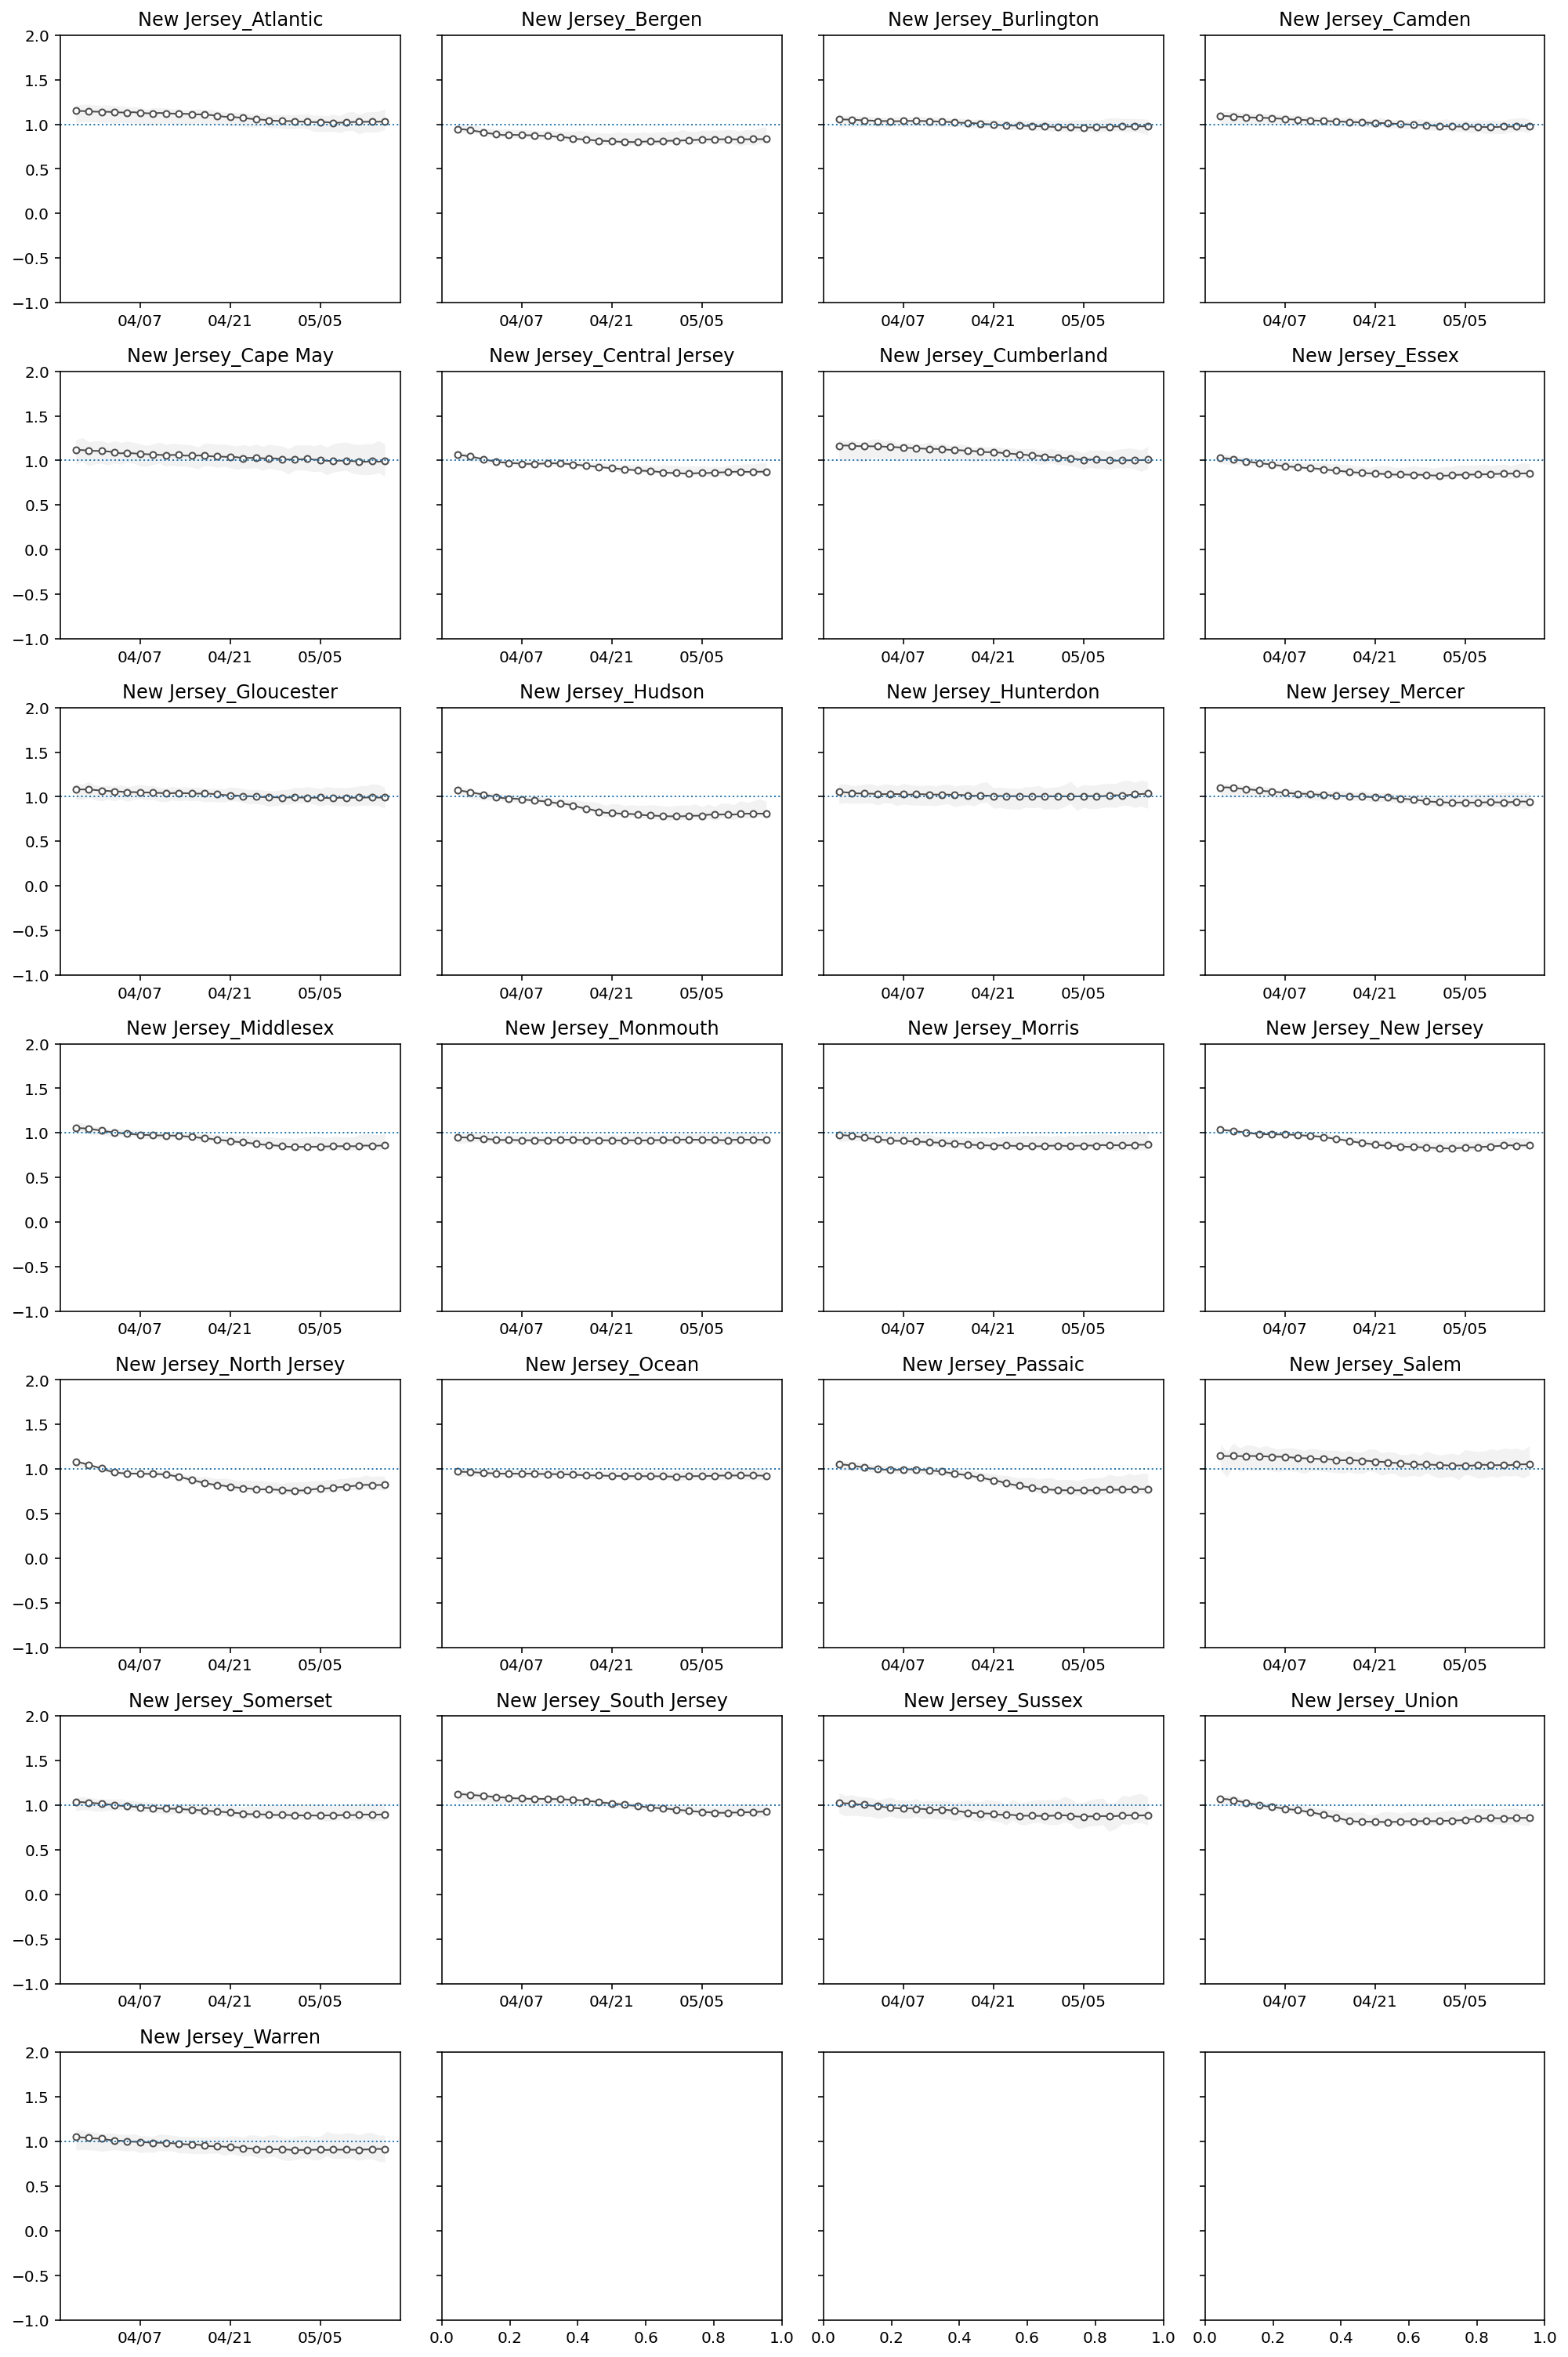

In [0]:
ncols = 4
nrows = int(np.ceil(results.index.levels[0].shape[0] / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(14, nrows*3),
    sharey='row')

for ax, (state, result) in zip(axes.flat, results.groupby('region')):
    plot_rt(state, result.droplevel(0), ax)

fig.tight_layout()
fig.set_facecolor('w')